In [35]:
# !pip install -q -U langchain-text-splitters rank_bm25 faiss-cpu
# !pip install -q -U sentence_transformers llama-index

In [36]:
# !pip install -q -U jq langchain_groq langchain_community
# !pip install -q -U langchain-huggingface

In [67]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.text_splitter import MarkdownHeaderTextSplitter

In [38]:
load_dotenv()

os.environ["LANGCHAIN_API_KEY"] = os.getenv('LangChain')
os.environ["HUGGINGFACE_API_KEY"] = os.getenv('HuggingFace')
os.environ["GROQ_API_KEY"] = os.getenv('Groq')

In [ ]:
docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]



e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# 'thenlper/gte-large'
hfembeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5",
                                     model_kwargs={'device': 'cpu'})
db = FAISS.from_documents(docs, hfembeddings)
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 4})

In [41]:
template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
rag_chain = prompt | llm

In [42]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

In [43]:
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage



In [44]:

# class GradeQuestion(BaseModel):
#     score: str = Field(
#         description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
#     )


# def question_rewriter(state: AgentState):
#     print(f"Entering question_rewriter with following state: {state}")

#     # Reset state variables except for 'question' and 'messages'
#     state["documents"] = []
#     state["on_topic"] = ""
#     state["rephrased_question"] = ""
#     state["proceed_to_generate"] = False
#     state["rephrase_count"] = 0

#     if "messages" not in state or state["messages"] is None:
#         state["messages"] = []

#     if state["question"] not in state["messages"]:
#         state["messages"].append(state["question"])

#     if len(state["messages"]) > 1:
#         conversation = state["messages"][:-1]
#         current_question = state["question"].content
#         messages = [
#             SystemMessage(
#                 content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
#             )
#         ]
#         messages.extend(conversation)
#         messages.append(HumanMessage(content=current_question))
#         rephrase_prompt = ChatPromptTemplate.from_messages(messages)
#         llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
#         prompt = rephrase_prompt.format()
#         response = llm.invoke(prompt)
#         better_question = response.content.strip()
#         print(f"question_rewriter: Rephrased question: {better_question}")
#         state["rephrased_question"] = better_question
#     else:
#         state["rephrased_question"] = state["question"].content
#     return state


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = state.get("rephrase_count", 0)  # Don't reset to 0, preserve existing count

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        
        # Create a proper conversation history string
        conversation_history = ""
        for msg in conversation:
            if isinstance(msg, HumanMessage):
                conversation_history += f"Human: {msg.content}\n"
            elif isinstance(msg, AIMessage):
                conversation_history += f"Assistant: {msg.content}\n"
        
        rephrase_prompt = f"""You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval.

Conversation history:
{conversation_history}

Current question: {current_question}

Please rephrase the current question to be a standalone question that incorporates relevant context from the conversation history:"""

        llm = ChatGroq(model="llama3-8b-8192", temperature=0.5)
        response = llm.invoke(rephrase_prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    
    return state


In [45]:
# def question_classifier(state: AgentState):
#     print("Entering question_classifier")
#     system_message = SystemMessage(
#         content=""" You are a classifier that determines whether a user's question is about one of the following topics

#     1. Gym History & Founder
#     2. Operating Hours
#     3. Membership Plans
#     4. Fitness Classes
#     5. Personal Trainers
#     6. Facilities & Equipment
#     7. Anything else about Peak Performance Gym

#     If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

#     """
#     )

#     human_message = HumanMessage(
#         content=f"User question: {state['rephrased_question']}"
#     )
#     grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
#     llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
#     structured_llm = llm.with_structured_output(GradeQuestion)
#     grader_llm = grade_prompt | structured_llm
#     result = grader_llm.invoke({})
#     state["on_topic"] = result.score.strip()
#     print(f"question_classifier: on_topic = {state['on_topic']}")
#     return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")
    
    prompt = f"""You are a classifier that determines whether a user's question is about one of the following topics:

1. Gym History & Founder
2. Operating Hours
3. Membership Plans
4. Fitness Classes
5. Personal Trainers
6. Facilities & Equipment
7. Anything else about Peak Performance Gym

User question: {state['rephrased_question']}

If the question IS about any of these topics, respond with only 'Yes'. Otherwise, respond with only 'No'.
Answer:"""
    
    llm = ChatGroq(model="llama3-8b-8192", temperature=0.5)
    
    try:
        response = llm.invoke(prompt)
        result = response.content.strip().lower()
        
        # Extract Yes or No from the response
        if 'yes' in result:
            state["on_topic"] = "Yes"
        else:
            state["on_topic"] = "No"
            
    except Exception as e:
        print(f"Error in question_classifier: {e}")
        # Default to Yes to be safe
        state["on_topic"] = "Yes"
    
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

In [46]:

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state



def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content="I'm sorry, but I cannot find the information you're looking for."
        )
    )
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

_retrieval_grader__.grade_prompt 
 input_variables=[] input_types={} partial_variables={} messages=[SystemMessage(content="You are a grader assessing the relevance of a retrieved document to a user question.\nOnly answer with 'Yes' or 'No'.\n\nIf the document contains information relevant to the user's question, respond with 'Yes'.\nOtherwise, respond with 'No'.", additional_kwargs={}, response_metadata={}), HumanMessage(content='User question: Who founded Peak Performance Gym?\n\nRetrieved document:\nPeak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.', additional_kwargs={}, response_metadata={})]

In [47]:


# class GradeDocument(BaseModel):
#     score: str = Field(
#         description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
#     )

# def retrieval_grader(state: AgentState):
#     print("Entering retrieval_grader")
#     system_message = SystemMessage(
#         content="""You are a grader assessing the relevance of a retrieved document to a user question.
# Only answer with 'Yes' or 'No'.

# If the document contains information relevant to the user's question, respond with 'Yes'.
# Otherwise, respond with 'No'."""
#     )

#     llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
#     structured_llm = llm.with_structured_output(GradeDocument)

#     relevant_docs = []
#     for doc in state["documents"]:
#         human_message = HumanMessage(
#             content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
#         )
#         grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
#         grader_llm = grade_prompt | structured_llm
#         result = grader_llm.invoke({})
#         print(
#             f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
#         )
#         if result.score.strip().lower() == "yes":
#             relevant_docs.append(doc)
#     state["documents"] = relevant_docs
#     state["proceed_to_generate"] = len(relevant_docs) > 0
#     print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
#     return state

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    
    llm = ChatGroq(model="llama3-8b-8192", temperature=0.5)
    
    relevant_docs = []
    for doc in state["documents"]:
        # Simplified prompt that works better with Groq
        prompt = f"""You are a grader assessing the relevance of a retrieved document to a user question.
Respond with only 'Yes' or 'No' - nothing else.

User question: {state['rephrased_question']}

Retrieved document: {doc.page_content}

Is this document relevant to the user's question? Answer only 'Yes' or 'No':"""
        
        try:
            response = llm.invoke(prompt)
            result = response.content.strip().lower()
            print("---------")
            print("__retrieval_grader__.response ",response)
            print(f"Grading document: {doc.page_content[:50]}... Result: {result}")
            print("---------")
            
            # Check if the response contains 'yes'
            if 'yes' in result:
                relevant_docs.append(doc)
                
        except Exception as e:
            print(f"Error while grading document: {e}")
            # If there's an error, include the document to be safe
            relevant_docs.append(doc)
            continue
    
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: Found {len(relevant_docs)} relevant documents")
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state


In [48]:

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"


In [49]:

# def refine_question(state: AgentState):
#     print("Entering refine_question")
#     rephrase_count = state.get("rephrase_count", 0)
#     if rephrase_count >= 2:
#         print("Maximum rephrase attempts reached")
#         return state
#     question_to_refine = state["rephrased_question"]
#     system_message = SystemMessage(
#         content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
# Provide a slightly adjusted version of the question."""
#     )
#     human_message = HumanMessage(
#         content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
#     )
#     refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
#     llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
#     prompt = refine_prompt.format()
#     response = llm.invoke(prompt)
#     refined_question = response.content.strip()
#     print(f"refine_question: Refined question: {refined_question}")
#     state["rephrased_question"] = refined_question
#     state["rephrase_count"] = rephrase_count + 1
#     return state


def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    
    question_to_refine = state["rephrased_question"]
    
    refine_prompt = f"""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question.

Original question: {question_to_refine}

Refined question:"""
    
    llm = ChatGroq(model="llama3-8b-8192", temperature=0.5)
    response = llm.invoke(refine_prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state


In [50]:

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

In [51]:
# !pip install -q -U langgraph

In [52]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [53]:


# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

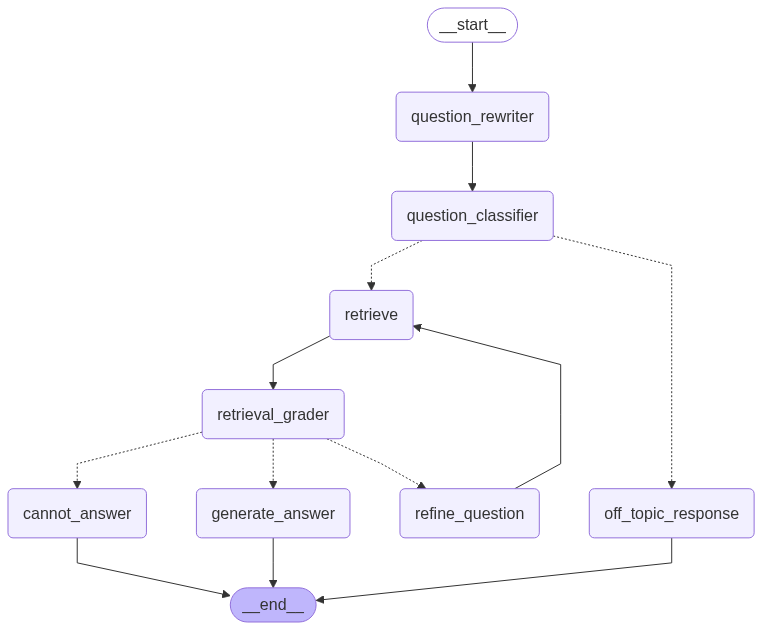

In [54]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [55]:
input_data = {
    "question": HumanMessage(
        content="What is the cancelation policy for Peak Performance Gym memberships?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader


e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 144, 'total_tokens': 146, 'completion_time': 0.00164681, 'prompt_time': 0.029376838, 'queue_time': 0.56388976, 'total_time': 0.031023648}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--1b65a428-51ba-4ed1-83b5-e781d712048a-0' usage_metadata={'input_tokens': 144, 'output_tokens': 2, 'total_tokens': 146}
Grading document: Peak Performance Gym is open Monday through Friday... Result: no
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 170, 'total_tokens': 172, 'completion_time': 0.001647, 'prompt_time': 0.068997638, 'queue_time': 0.277881261, 'total_time': 0.070644638}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_

e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 193, 'total_tokens': 195, 'completion_time': 0.001642951, 'prompt_time': 0.039729357, 'queue_time': 0.7721690139999999, 'total_time': 0.041372308}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--f4cc2fff-880c-4e88-b815-ced68bd1c95a-0' usage_metadata={'input_tokens': 193, 'output_tokens': 2, 'total_tokens': 195}
Grading document: Peak Performance Gym is open Monday through Friday... Result: no
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 219, 'total_tokens': 221, 'completion_time': 0.001701428, 'prompt_time': 0.024914006, 'queue_time': 0.265955974, 'total_time': 0.026615434}, 'model_name': 'llama3-8b-8192', 'system_finger

e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 210, 'total_tokens': 212, 'completion_time': 0.004395953, 'prompt_time': 0.150772366, 'queue_time': 0.308590644, 'total_time': 0.155168319}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--a102a2c3-fc9f-41eb-af9d-ef111976cdac-0' usage_metadata={'input_tokens': 210, 'output_tokens': 2, 'total_tokens': 212}
Grading document: Peak Performance Gym is open Monday through Friday... Result: no
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 236, 'total_tokens': 238, 'completion_time': 0.001669909, 'prompt_time': 0.026705923, 'queue_time': 0.26319713, 'total_time': 0.028375832}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 

{'messages': [HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'Here\'s a slightly adjusted version of the question:\n\n"What are the specific cancellation terms, procedures, and potential fees or penalties associated with terminating a membership at Peak Performance Gym, including any notice periods, refund policies, and any other relevant details?"\n\nThis refined question is more specific and detailed, aiming to provide more accurate and relevant information about the cancellation process and any associated costs at Peak Performance Gym.',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', addition

In [66]:
input_data = {
    "question": HumanMessage(
        content="Tell me about the trainers in Peak Performance Gym ?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter
question_rewriter: Rephrased question: Here's a rephrased version of the question that incorporates relevant context from the conversation history:

"What information is available about the trainers at Peak Performance Gym, similar to how Apple is a well-known company?"

This rephrased question still asks about the trainers at Peak Performance Gym, but also provides context by mentioning Apple, which was previously discussed in the conversation. This can help improve the question's relevance and retrievability in a search database.
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader


e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='Yes' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 217, 'total_tokens': 219, 'completion_time': 0.001838974, 'prompt_time': 0.024776974, 'queue_time': 0.266247366, 'total_time': 0.026615948}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--46f53fd0-c758-4371-977d-f3283b4987f0-0' usage_metadata={'input_tokens': 217, 'output_tokens': 2, 'total_tokens': 219}
Grading document: Peak Performance Gym was founded in 2015 by former... Result: yes
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 223, 'total_tokens': 225, 'completion_time': 0.003035318, 'prompt_time': 0.076475129, 'queue_time': 0.611765741, 'total_time': 0.079510447}, 'model_name': 'llama3-8b-8192', 'system_fingerprint

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me about the trainers in Peak Performance Gym ?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Based on the context provided, I can answer the question.\n\nPeak Performance Gym is a fitness center that offers personalized fitness solutions, and trainers are likely an essential part of their equipment. Given the context, it's reasonable to assume that trainers commonly used in a gym like Peak Performance Gym would be high-quality athletic footwear designed for various fitness activities, such as running, strength training, or group fitness classes.\n\nIn this case, the types of athletic footwear, such as trainers, commonly used in Peak Performance Gym would likely be brands like Nike, Adidas, or Asics, which are popu

In [ ]:
input_data = {
    "question": HumanMessage(
        content="Tell me about the trainers in Peak Performance Gym ?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 4}})

Entering question_rewriter
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader


e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='Yes' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 164, 'total_tokens': 166, 'completion_time': 0.003001958, 'prompt_time': 0.10905564, 'queue_time': 0.284432388, 'total_time': 0.112057598}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--5f21c234-1cf0-4112-a041-21b50c57f167-0' usage_metadata={'input_tokens': 164, 'output_tokens': 2, 'total_tokens': 166}
Grading document: Personal trainers at Peak Performance Gym are all ... Result: yes
---------
---------
__retrieval_grader__.response  content='Yes' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 150, 'total_tokens': 152, 'completion_time': 0.001651199, 'prompt_time': 0.031209417, 'queue_time': 0.434432626, 'total_time': 0.032860616}, 'model_name': 'llama3-8b-8192', 'system_fingerprint

{'messages': [HumanMessage(content='Tell me about the trainers in Peak Performance Gym ?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='According to the provided context, the trainers at Peak Performance Gym are all certified professionals with a minimum of 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. The head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(id='50002e63-4952-49a2-8ca9-d7ee23b43974', metadata={'source': 'trainers.txt'}, page_content='Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can

In [56]:
input_data = {
    "question": HumanMessage(content="Who founded Peak Performance Gym?")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader


e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='Yes' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 132, 'total_tokens': 134, 'completion_time': 0.003060033, 'prompt_time': 0.045648599, 'queue_time': 0.5439525390000001, 'total_time': 0.048708632}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--b792ea69-0b1f-4996-957e-f0ed0bbcfd3a-0' usage_metadata={'input_tokens': 132, 'output_tokens': 2, 'total_tokens': 134}
Grading document: Peak Performance Gym was founded in 2015 by former... Result: yes
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 146, 'total_tokens': 148, 'completion_time': 0.002984575, 'prompt_time': 0.050049822, 'queue_time': 0.26583954899999995, 'total_time': 0.053034397}, 'model_name': 'llama3-8b-8192', 'sys

{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='According to the context, Peak Performance Gym was founded by Marcus Chen, a former Olympic athlete, in 2015.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(id='a37559da-b47b-4d6d-ba44-5247351d9e4c', metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.')],
 'on_topic': 'Yes',
 'rephrased_question': 'Who founded Peak Performance Gym?',
 'proceed_to_generate': True,
 'rephrase_count': 0,
 'question': HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={})}

In [57]:
input_data = {"question": HumanMessage(content="When did he start it?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter
question_rewriter: Rephrased question: What is the year that Marcus Chen, the founder of Peak Performance Gym, opened the gym?
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 4 documents
Entering retrieval_grader


e:\Python_PIP\RAG\virtualenv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


---------
__retrieval_grader__.response  content='Yes' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 145, 'total_tokens': 147, 'completion_time': 0.00165054, 'prompt_time': 0.030080681, 'queue_time': 0.265649839, 'total_time': 0.031731221}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--8a0e10ea-8a39-4db3-9968-a7e5496816fa-0' usage_metadata={'input_tokens': 145, 'output_tokens': 2, 'total_tokens': 147}
Grading document: Peak Performance Gym was founded in 2015 by former... Result: yes
---------
---------
__retrieval_grader__.response  content='No' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 151, 'total_tokens': 153, 'completion_time': 0.002866387, 'prompt_time': 0.061270272, 'queue_time': 0.473177669, 'total_time': 0.064136659}, 'model_name': 'llama3-8b-8192', 'system_fingerprint'

{'messages': [HumanMessage(content='Who founded Peak Performance Gym?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='According to the context, Peak Performance Gym was founded by Marcus Chen, a former Olympic athlete, in 2015.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='When did he start it?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='According to the context, Marcus Chen, the founder of Peak Performance Gym, opened the gym in 2015.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(id='a37559da-b47b-4d6d-ba44-5247351d9e4c', metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.')],
 'on_topic': 'Y

In [58]:
input_data = {"question": HumanMessage(content="What does the company Apple do?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'What does the company Apple do?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}

In [59]:
#